In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta, date

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create session (link) from Python to the DB
session = Session(engine)

In [10]:
# Create inspector
inspector = inspect(engine)

# Inspect the measurement table
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Inspect the station table
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

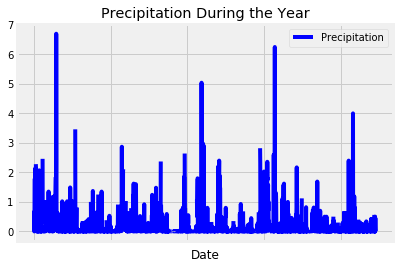

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
recent_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date_list = list(np.ravel(recent_date_query))
recent_date = dt.datetime.strptime(recent_date_list[0], "%Y-%m-%d").date()

year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_12_months_precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).\
    filter(Measurement.date <= recent_date).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(last_12_months_precipitation, columns=['Date', 'Precipitation']).set_index('Date')

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(color="blue")
plt.title("Precipitation During the Year")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset
session.query(Measurement.station).distinct().count()

9

In [15]:
# Figure out the most active stations (stations have the most rows)
# List the stations and the counts in descending order
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Get the most active station
top_station_query = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

top_station = top_station_query[0]
top_station

'USC00519281'

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature for the most active station
top_station_stats_query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == top_station)

top_station_stats = top_station_stats_query[0]
top_station_stats

(54.0, 85.0, 71.66378066378067)

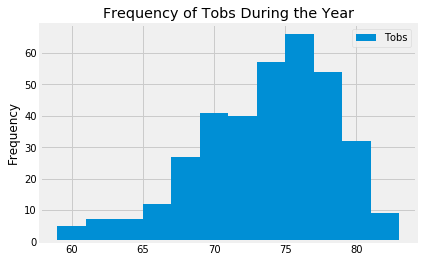

In [18]:
# Choose the station with the highest number of temperature observations
most_tobs_station_query = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()

most_tobs_station = most_tobs_station_query[0]

# Query the last 12 months of temperature observation data for this station
tobs_recent_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).\
    filter(Measurement.station == most_tobs_station).first()

tobs_recent_date_list = list(np.ravel(tobs_recent_date_query))
tobs_recent_date = dt.datetime.strptime(tobs_recent_date_list[0], "%Y-%m-%d").date()

tobs_year_ago = tobs_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and tobs scores
last_12_months_tobs = session.query(Measurement.date, Measurement.tobs).\
     filter(Measurement.date >= tobs_year_ago).\
     filter(Measurement.date <= tobs_recent_date).\
     filter(Measurement.station == most_tobs_station).\
     order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
tobs_df = pd.DataFrame(last_12_months_tobs, columns=['Date', 'Tobs']).set_index('Date')

# Sort the dataframe by date
tobs_df = tobs_df.sort_values(by=['Date'])

# Plot the results as a histogram
fig, ax = plt.subplots()

ax.set_title("Frequency of Tobs During the Year")
ax.set_ylabel("Frequency")

x_values = tobs_df["Tobs"]
num_bins = 12

ax.hist(x_values, bins=num_bins)
ax.legend()
plt.show()

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_dates_temps = calc_temps('2011-02-28', '2011-03-05')
trip_dates_temps

[(61.0, 69.75510204081633, 75.0)]

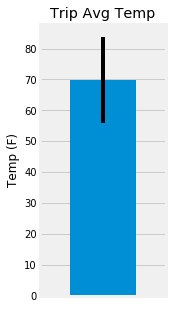

In [21]:
# Plot the results from your previous query as a bar chart
# Use "Trip Avg Temp" as the Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_dates_temps_df = pd.DataFrame(trip_dates_temps, columns=['tmin', 'tave', 'tmax'])

y_errbar = trip_dates_temps_df['tmax'] - trip_dates_temps_df['tmin']

fig, ax = plt.subplots(figsize=(2,5))
ax.set_title("Trip Avg Temp")
ax.set_ylabel("Temp (F)")
ax.bar(0, trip_dates_temps_df['tave'], yerr = y_errbar)
ax.set_xlim(-0.75, 0.75)
ax.set_xticks([])
ax.grid(axis="x")
plt.show()

In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
trip_dates_precipitation = session.query(*sel).filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2011-02-28').\
    filter(Measurement.date <= '2011-03-05').\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

trip_dates_precipitation

[('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  2.33),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.23),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.19),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.96),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.44),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.38),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.63),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

# Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# Calculate the daily normals for your trip

# Push each tuple of calculations into a list called `normals`
normals = []

# Create list for range of dates for %m-%d format
datelist = []

# Create list for range of dates for %Y-%m-%d format
fulldatelist = []

# Function to get range of dates using start date and end date
def date_range(date1, date2):
      
    days_difference = date2 - date1
    date_range_list = [date1 + timedelta(i) for i in range(days_difference.days + 1)]
    return date_range_list
    
# Set the start date (2011-02-28) and end date (2011-03-05) of the trip 
trip_start_date = date(2011, 2, 28)
trip_end_date = date(2011, 3, 5)

# Use the start and end date to create a range of dates. Strip off the year and save a list of %m-%d strings
for tripdate in date_range(trip_start_date, trip_end_date):
    datelist.append(tripdate.strftime("%m-%d"))

# Save a list of %Y-%m-%d strings for the x-axis in the area plot
for tripdate in date_range(trip_start_date, trip_end_date):
    fulldatelist.append(tripdate.strftime("%Y-%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
for tripdate in datelist:
    normal_calc = daily_normals(tripdate)
    for record in normal_calc:
        normals.append(record)

normals

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_prcp_df = pd.DataFrame(normals, columns=['tmin','tavg', 'tmax'])
trip_prcp_df['date'] = fulldatelist
trip_prcp_df.set_index('date', inplace=True)
trip_prcp_df

,tmin,tavg,tmax
date,,,
2011-02-28,65.0,70.655172,80.0
2011-03-01,64.0,70.032787,76.0
2011-03-02,61.0,70.366667,78.0
2011-03-03,60.0,70.068966,78.0
2011-03-04,57.0,69.272727,77.0
2011-03-05,60.0,67.890909,76.0


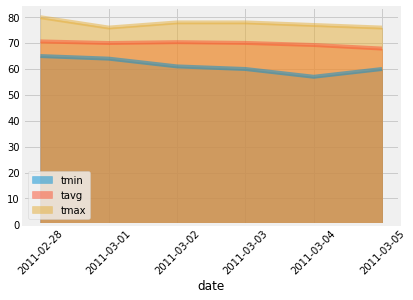

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
x_ticks_dates = trip_prcp_df.index.tolist()

trip_prcp_df.plot(kind="area", stacked=False, rot=45)
plt.xticks(range(len(x_ticks_dates)), x_ticks_dates)
plt.show()